In [1]:
pip install uproot awkward


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.8/383.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.0/887.0 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 27.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mplhep

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 37.3 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [3]:
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import uproot
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.special import wofz
import mplhep as hep

# Hicimos una configuracion global de estilo para que las graficas sean similares a las presentadas
#por el CERN
plt.style.use([hep.style.ROOT, hep.style.firamath])

plt.rcParams.update({
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})


# ESTUDIO DE DATOS SIMULADOS TIPO CMS: Analisis de energía  transversal faltante y reconstruccion del boson Z.

## *Estefanía Zapata Valderrama, Santiago Angulo*

### Universidad de Antioquia, Instituto de Física  
**Curso:** Métodos Computacionales  
**Docente:** Juan Marcos Marin 


---

El Gran Colisionador de Hadrones (LHC) es el acelerador de partículas más grande del mundo, donde protones colisionan a energías del orden de los **TeV** para estudiar la estructura fundamental de la materia. Uno de sus experimentos principales es el **CMS (Compact Muon Solenoid)**, un detector multipropósito capaz de medir una amplia variedad de fenómenos físicos, como el bosón de Higgs o señales de nueva física más allá del Modelo Estándar.

En este proyecto, se analizarán **datos simulados de colisiones protón-protón** con estado final de leptones cargados, en este caso muones:

$$
p p \to Z/\gamma^* \to \mu^+ \mu^-,
$$

con el objetivo de:
- Calcular y comparar la **energía transversal faltante (MET)**.  
- Reconstruir la **masa invariante del par de muones**, buscando la señal del bosón \(Z\).  
- Realizar un **análisis estadístico** de los eventos.  

Los datos provienen de un **pipeline de simulación estándar en física de altas energías**:  

1. **MadGraph5\_aMC@NLO** → generación de colisiones a nivel partónico.  
2. **PYTHIA8** → hadronización y procesos de radiación.  
3. **Delphes3** → simulación rápida del detector CMS.  

Este conjunto simulado ofrece una aproximación realista a los datos experimentales del CERN y permite aplicar técnicas de análisis similares a las usadas en física de colisionadores.


## El detector CMS y coordenadas relevantes: $\phi$, $\eta$ y $p_T$

El detector CMS está compuesto por múltiples subsistemas diseñados para medir con precisión la trayectoria, momento y energía de las partículas producidas en las colisiones. Para esto, no es conveniente utilizar directamente las coordenadas cartesianas $(x, y, z)$. En su lugar, se emplea un sistema de variables adaptado a la simetría cilíndrica de los detectores y al eje del haz de protones. Entre las más relevantes se encuentran:


### El ángulo azimutal $\phi$

El ángulo azimutal $\phi$ se mide en el plano transversal al haz ($x$-$y$) y corresponde a la dirección en que la partícula se propaga en dicho plano. Se define como:

$$
\phi = \arctan\left(\frac{p_y}{p_x}\right),
$$

con valores en el rango $[-\pi, \pi]$. Esta variable resulta esencial para caracterizar la distribución de partículas alrededor del detector y estudiar su simetría azimutal.


### La pseudo-rapidez $\eta$

La pseudo-rapidez es una variable relacionada con el ángulo polar $\theta$ respecto al eje del haz ($z$). Se define como:

$$
\eta = -\ln\left(\tan\frac{\theta}{2}\right).
$$

A diferencia de $\theta$, la variable $\eta$ es más conveniente para procesos relativistas ya que es invariante bajo boosts longitudinales a lo largo del eje del haz. Esto permite comparar resultados en diferentes sistemas de referencia, lo que resulta fundamental en el análisis de colisionadores.


###  El momento transversal $p_T$

El momento transversal es la componente del momento lineal en el plano perpendicular al haz:

$$
p_T = \sqrt{p_x^2 + p_y^2}.
$$

Dado que la dirección longitudinal ($z$) es difícil de balancear en una colisión protón-protón debido a la naturaleza compuesta de los protones, el momento transversal se convierte en la magnitud clave para el análisis de eventos.

En particular, el $p_T$ elevado de los muones es una señal característica de procesos de interés, como la producción del bosón $Z$, mientras que los muones de bajo $p_T$ suelen estar asociados a procesos de fondo.


In [4]:
# Abrir el archivo ROOT
archivo_root = "/kaggle/input/rootfiles/tag_1_delphes_events.root" 
file = uproot.open(archivo_root)
file.keys()
tree = file["Delphes"]
# Cargamos las ramas necesarias para muones
muon_arrays = tree.arrays(
    ["Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.Charge"],
    library="ak")
# Cargamos directamente la rama de MET (Todas las particulas)
met_arrays = tree.arrays(
    ["MissingET.MET"],
    library="ak"
) 


In [5]:
#Calcular MET manualmente a partir de partículas

# Cargar ramas de partículas
particle_arrays = tree.arrays(["Particle.PT", "Particle.Phi"], library="ak") #Todas las particulas

# Extraer pT y phi
p_pts  = particle_arrays["Particle.PT"]
p_phis = particle_arrays["Particle.Phi"]

# Calcular px y py para cada partícula
px_parts = p_pts * np.cos(p_phis)
py_parts = p_pts * np.sin(p_phis)

# Sumar por evento
sum_px = ak.sum(px_parts, axis=1)
sum_py = ak.sum(py_parts, axis=1)

# MET calculada: magnitud del vector (-sum_px, -sum_py)
met_calc = np.sqrt((-ak.to_numpy(sum_px))**2 + (-ak.to_numpy(sum_py))**2)

# MET registrada en Delphes
met_delphes = ak.to_numpy(met_arrays["MissingET.MET"])

print("Eventos:", len(met_calc))
print(f"MET calculada (media) = {met_calc.mean():.3f} GeV")
print(f"MET Delphes (media)   = {met_delphes.mean():.3f} GeV")

Eventos: 10000
MET calculada (media) = 92.879 GeV
MET Delphes (media)   = 10.984 GeV


## Energía Transversal Faltante (MET)

La **energía transversal faltante**, \( \vec{E}_T^{\,miss} \), es una cantidad crucial en física de colisionadores. Se define como el vector negativo de la suma de todos los momentos transversales medidos en un evento:

$$
\vec{E}_T^{\,miss} = - \sum_{i} \vec{p}_{T,i}.
$$

Su magnitud se conoce como MET:

$$
\text{MET} = \left| \vec{E}_T^{\,miss} \right| = \sqrt{\left(\sum_i p_{x,i}\right)^2 + \left(\sum_i p_{y,i}\right)^2}.
$$

La MET aparece cuando partículas **no interaccionan con el detector**, escapando sin ser registradas. Los principales contribuyentes son:

- **Neutrinos**: partículas neutras que atraviesan el detector sin dejar señal.
- **Partículas más allá del Modelo Estándar**: como candidatos a materia oscura, que se manifestarían como un exceso en la MET.
- **Limitaciones experimentales**: ineficiencias en la detección o resolución limitada en la medición del momento.

En este proyecto, se calculará la MET a partir de las particulas detectados y se comparará con la MET reconstruida por el software de simulación (Delphes).


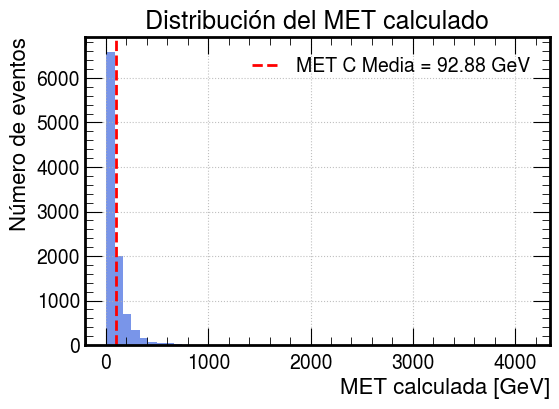

In [6]:
#Histograma MET (Calculada)
met_c_mean = met_calc.mean()

plt.figure(figsize=(6,4))
plt.hist(met_calc, bins=50, color="royalblue", alpha=0.7)
plt.axvline(met_c_mean, color="red", linestyle="--", linewidth=2, label=f"MET C Media = {met_c_mean:.2f} GeV")
plt.xlabel("MET calculada [GeV]")
plt.ylabel("Número de eventos")
plt.title("Distribución del MET calculado")
plt.legend()
plt.grid(True)
plt.show()


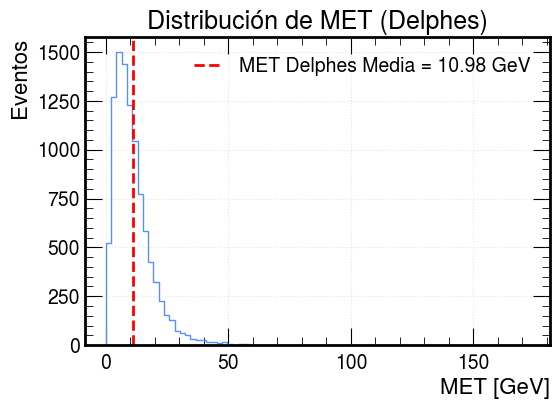

In [7]:
# Histograma de MET (Delphes)
met_d_mean = met_delphes.mean()

plt.figure(figsize=(6,4))
plt.hist(ak.to_numpy(met_arrays["MissingET.MET"]), bins=80, histtype='step')
plt.axvline(met_d_mean, color="red", linestyle="--", linewidth=2, label=f"MET Delphes Media = {met_d_mean:.2f} GeV")
plt.xlabel("MET [GeV]")
plt.ylabel("Eventos")
plt.title("Distribución de MET (Delphes)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


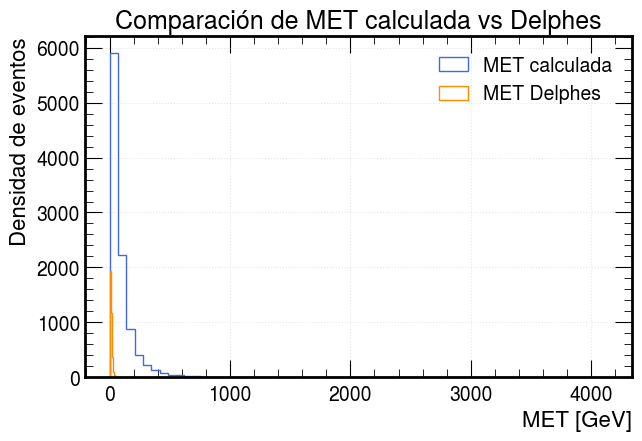

In [8]:
met_calc_np     = np.array(met_calc)   # MET calculada 
met_delphes_np  = np.array(met_delphes)  # MET reconstruida por Delphes

plt.figure(figsize=(7,5))

# histogramas
plt.hist(met_calc_np, bins=60, histtype='step', label="MET calculada", color="royalblue")
plt.hist(met_delphes_np, bins=60, histtype='step', label="MET Delphes", color="darkorange")
plt.xlabel("MET [GeV]")
plt.ylabel("Densidad de eventos")
plt.title("Comparación de MET calculada vs Delphes")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Reconstrucción de la masa invariante y el bosón $Z$

Uno de los métodos fundamentales en el análisis de colisionadores es la reconstrucción de la **masa invariante** de un sistema de partículas a partir de sus cuatro-momentos. Esta técnica permite identificar partículas intermedias como el bosón $Z$ a partir de sus productos de desintegración.

En relatividad especial, cada partícula se describe por su **cuatro-momento**:

$$
p^\mu = (E, \vec{p}) = (E, p_x, p_y, p_z),
$$

donde \( E \) es la energía de la partícula y \( \vec{p} = (p_x, p_y, p_z) \) es su momento lineal tridimensional, donde se reconstruyen las componentes cartesianas del momento a partir de las variables determinadas para la geometria cilindrica del detector, de la forma: 


$$
\begin{aligned}
p_x &= p_T \cos \phi, \\
p_y &= p_T \sin \phi, \\
p_z &= p_T \sinh \eta.
\end{aligned}
$$


El cuadrado del cuatro-momento está relacionado con la masa en reposo de la partícula:

$$
p^\mu p_\mu = E^2 - |\vec{p}|^2 = m^2.
$$

Dadas dos partículas con cuatro-momentos \( p^\mu_1 \) y \( p^\mu_2 \), la masa invariante del sistema se define como:

$$
m_{12}^2 = (p^\mu_1 + p^\mu_2)^2 = (E_1 + E_2)^2 - |\vec{p}_1 + \vec{p}_2|^2.
$$

Esta cantidad es un **invariante de Lorentz**, lo que significa que no depende del sistema de referencia en el que se mida.


##  El bosón $Z$

El **bosón neutro \( Z \)** es una partícula mediadora de la interacción débil, junto con los bosones cargados \( W^\pm \). Fue descubierto en 1983 en el CERN y constituye una de las piedras angulares del **Modelo Estándar**.

Su masa está medida con gran precisión:

$$
m_Z \simeq 91.2 \, \text{GeV}/c^2.
$$

En colisiones protón-protón, un proceso común es:

$$
pp \to Z/\gamma^* \to \mu^+ \mu^-,
$$

donde un bosón \( Z \) (o un fotón virtual \( \gamma^* \)) se desintegra en un par de muón y antimuón.

Cuando se reconstruye la masa invariante de muchos pares \( \mu^+ \mu^- \) en el detector, la distribución \( m_{\mu\mu} \) exhibe un **pico resonante** alrededor de la masa del bosón \( Z \).

Este pico es una **firma experimental inconfundible** de la producción del bosón \( Z \). Además:

- Sirve como calibración del detector, ya que la masa del \( Z \) es conocida con gran exactitud.
- Permite realizar estudios de precisión de la interacción electrodébil.
- Es la base para búsquedas de nueva física: una resonancia adicional en la distribución \( m_{\mu\mu} \) podría indicar la presencia de un nuevo bosón, como un \( Z' \) predicho en teorías de gran unificación.


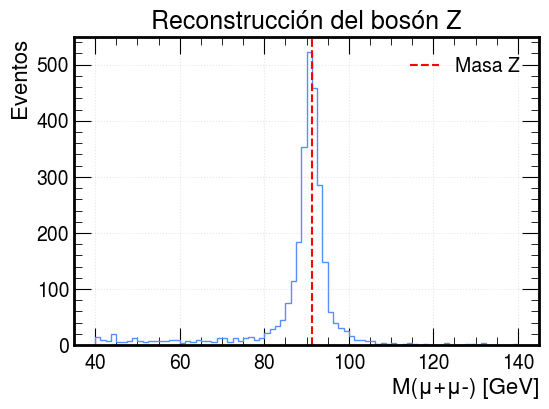

In [9]:
mu_mass = 0.1056583745  # GeV, masa del muón
z_masses = []

# Recorre eventos, arma combinaciones (μ+,μ−)(μ+,μ−) y guarda la mejor masa por evento.
for pts, etas, phis, charges in zip(muon_arrays["Muon.PT"],
                                    muon_arrays["Muon.Eta"],
                                    muon_arrays["Muon.Phi"],
                                    muon_arrays["Muon.Charge"]):
    pts = np.array(pts)
    etas = np.array(etas)
    phis = np.array(phis)
    charges = np.array(charges)

    if len(pts) < 2:
        z_masses.append(np.nan)
        continue

    best_mass = np.nan
    for i in range(len(pts)):
        for j in range(i+1, len(pts)):
            if charges[i] * charges[j] >= 0:
                continue

            px1, py1, pz1 = pts[i]*np.cos(phis[i]), pts[i]*np.sin(phis[i]), pts[i]*np.sinh(etas[i])
            px2, py2, pz2 = pts[j]*np.cos(phis[j]), pts[j]*np.sin(phis[j]), pts[j]*np.sinh(etas[j])

            E1 = np.sqrt(px1**2 + py1**2 + pz1**2 + mu_mass**2)
            E2 = np.sqrt(px2**2 + py2**2 + pz2**2 + mu_mass**2)

            mass2 = max((E1+E2)**2 - ((px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2), 0)
            mass = np.sqrt(mass2)

            if np.isnan(best_mass) or abs(mass - 91.1876) < abs(best_mass - 91.1876):
                best_mass = mass
    z_masses.append(best_mass)

z_masses = np.array(z_masses)

# Histograma 
plt.figure(figsize=(6,4))
plt.hist(z_masses[~np.isnan(z_masses)], bins=80, range=(40,140), histtype='step')
plt.axvline(91.1876, color='red', linestyle='--', label="Masa Z")
plt.xlabel("M(μ+μ-) [GeV]")
plt.ylabel("Eventos")
plt.title("Reconstrucción del bosón Z")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Ajuste del pico del bosón Z

En los análisis de colisiones protón–protón en el LHC, una de las señales más claras de la producción del bosón **Z** es el **pico característico en la distribución de la masa invariante de pares leptónicos** (electrones o muones). Este pico se observa alrededor de los **91 GeV**, que corresponde a la masa del bosón Z medida experimentalmente.

Para estudiar esta distribución y extraer información física, es común realizar un **ajuste (fit)** de los datos utilizando funciones que describan tanto la señal como el fondo.

### Distribución de Breit–Wigner relativista

La señal asociada al bosón Z se modela mediante una **distribución de Breit–Wigner**, que describe la forma esperada de una **resonancia inestable**. El bosón Z, al ser una partícula de vida finita, tiene una anchura de decaimiento (\( \Gamma_Z \)) que se refleja en la dispersión del pico.

La función es:

$$
BW(m) = \frac{1}{(m^2 - M_Z^2)^2 + (M_Z \Gamma_Z)^2}
$$

**Donde:**
- \( m \): masa invariante reconstruida del par leptónico  
- \( M_Z \): masa central del bosón Z  
- \( \Gamma_Z \): anchura total de decaimiento del bosón Z  

Esta forma permite modelar el **máximo en torno a la masa del Z** y su caída característica hacia masas más altas o más bajas.


### Término de fondo

No todos los pares leptónicos observados provienen de la desintegración del bosón Z. Existen **procesos de fondo** (como producción continua de pares leptónicos vía fotones virtuales \( \gamma^* \to l^+l^- \), o combinaciones aleatorias de leptones) que contribuyen a la distribución.

Estos eventos de fondo no muestran un pico definido, sino un comportamiento más **suave y continuo**. Para describirlos se acostumbra usar funciones sencillas, como un **término lineal**:

$$
B(m) = a + b \, m
$$

**Donde:**  
\( a \) y \( b \) son parámetros libres que se ajustan a los datos.


### Función total de ajuste

El modelo completo de ajuste combina la señal y el fondo:

$$
F(m) = N \cdot BW(m) + (a + b \, m)
$$

**Donde:**  
\( N \) es un factor de normalización que ajusta la contribución relativa de la resonancia.

El uso de la función **Breit–Wigner más un fondo lineal** es una estrategia estándar en física de partículas para el estudio de resonancias. Permite describir simultáneamente la señal (bosón Z) y los procesos de fondo, obteniendo parámetros físicos relevantes y un análisis más completo.


Masa Z (ajustada): 90.981 ± 0.022 GeV
Ancho Γ (ajustado): 4.116 ± 0.066 GeV


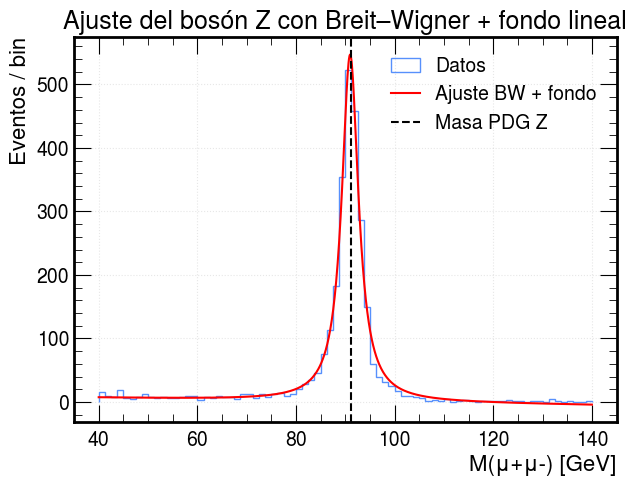

In [10]:
# función de ajuste 
def breit_wigner(x, A, m0, gamma, B, C):
    """
    A: normalización (altura del pico)
    m0: masa central de la resonancia (bosón Z)
    gamma: ancho (decay width)
    B, C: parámetros del fondo lineal
    """
    bw = A * (gamma**2 / ((x - m0)**2 + (gamma**2)/4))
    background = B + C*x
    return bw + background

# datos
masses = z_masses[~np.isnan(z_masses)]
counts, bins = np.histogram(masses, bins=80, range=(40,140))
bin_centers = 0.5*(bins[1:] + bins[:-1])

# Ajuste con curve_fit 
p0 = [1000, 91.0, 2.5, 10, -0.1]  # valores iniciales aproximados
params, cov = curve_fit(breit_wigner, bin_centers, counts, p0=p0)

A_fit, m0_fit, gamma_fit, B_fit, C_fit = params
errors = np.sqrt(np.diag(cov))

print(f"Masa Z (ajustada): {m0_fit:.3f} ± {errors[1]:.3f} GeV")
print(f"Ancho Γ (ajustado): {gamma_fit:.3f} ± {errors[2]:.3f} GeV")

# Grafica
plt.figure(figsize=(7,5))
plt.hist(masses, bins=80, range=(40,140), histtype='step', label="Datos")
x_plot = np.linspace(40, 140, 1000)
plt.plot(x_plot, breit_wigner(x_plot, *params), 'r-', label="Ajuste BW + fondo")
plt.axvline(91.1876, color='k', linestyle='--', label="Masa PDG Z")
plt.xlabel("M(μ+μ-) [GeV]")
plt.ylabel("Eventos / bin")
plt.title("Ajuste del bosón Z con Breit–Wigner + fondo lineal")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


###  Conclusiones

**1. Energía transversal faltante (MET):**  
En el análisis se calcularon dos valores distintos de la MET debido a las diferencias en el método de estimación empleado:

- Uno obtenido de forma simplificada mediante la suma vectorial de los momentos transversales,  
- Otro extraído de la simulación más realista con *Delphes*, donde se consideran efectos de detector y resolución instrumental.  

El estudio del MET mostró que los valores calculados manualmente a partir del archivo .particles y los obtenidos del archivo .missingmet.et presentan diferencias notables, aunque se esperaba un valor parecido, esta diferencia ha dado pie a estudiar las razones de que esto suceda, La principal la razon es la informacion que tiene cada tipo de archivo:
- el archivo .particles contiene información detallada de cada partícula reconstruida en el evento (momento transverso, ángulo azimutal, energía, etc.), pero no siempre incluye todos los efectos experimentales como pérdidas de energía o resolución del detector.
- el archivo .missingmet.et ya considera efectos de detector, ruido y posibles partículas invisibles, lo cual lo hace más cercano a lo que se mide experimentalmente.

Esta discrepancia es esperada y muestra la importancia de los efectos experimentales en la física de altas energías. En conjunto, los resultados evidencian que la MET es una variable sensible al modelado de los eventos y crucial para identificar procesos con partículas no detectadas.


**2. Reconstrucción de la masa invariante del par de muones (bosón $Z$):**  
A partir de los eventos simulados de colisiones $pp \to \mu^+\mu^-$, se construyó la distribución de la masa invariante del par de muones.  
Los resultados muestran un pico centrado alrededor de los $91 \, \text{GeV}$, valor consistente con la masa conocida del bosón $Z$.  

Esto valida la metodología aplicada y demuestra que la simulación reproduce correctamente la señal esperada, permitiendo la identificación del bosón a partir de sus productos de decaimiento.


**3. Ajuste estadístico de la distribución:**  
Se realizó un ajuste gaussiano sobre la distribución de masas invariantes, lo que permitió caracterizar la posición del pico (masa central) y la anchura (resolución del detector).  

Este análisis estadístico complementa la reconstrucción del bosón $Z$, pues ofrece una cuantificación precisa de sus parámetros, además de servir como herramienta para comparar simulación y datos experimentales.  

En este sentido, el objetivo de *“realizar un análisis estadístico de los eventos”* se cumple a través del ajuste, ya que permitió validar la reconstrucción y obtener parámetros relevantes de manera sistemática.


##  Referencias

* CMS Collaboration. (2008). *The CMS experiment at the CERN LHC*. Journal of Instrumentation, 3(S08004), S08004.  
  [https://doi.org/10.1088/1748-0221/3/08/S08004](https://doi.org/10.1088/1748-0221/3/08/S08004)

* CMS Collaboration. (2019). *Performance of missing transverse momentum reconstruction in proton-proton collisions at √s = 13 TeV using the CMS detector*. Journal of Instrumentation, 14(07), P07004.  
  [https://doi.org/10.1088/1748-0221/14/07/P07004](https://doi.org/10.1088/1748-0221/14/07/P07004)

* LHC Closer. (s.f.). *Beam lifetime*. Recuperado de  
  [https://www.lhc-closer.es/taking_a_closer_look_at_lhc/0.beam_lifetime](https://www.lhc-closer.es/taking_a_closer_look_at_lhc/0.beam_lifetime)

* CERN. (s.f.). *How a detector works*. Recuperado de  
  [https://home.web.cern.ch/science/experiments/how-detector-works](https://home.web.cern.ch/science/experiments/how-detector-works)

* Wikipedia. (s.f.). *Distribución de Breit-Wigner relativista*. En *Wikipedia*. Recuperado de  
  [https://es.wikipedia.org/wiki/Distribuci%C3%B3n_de_Breit-Wigner_relativista](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_de_Breit-Wigner_relativista)

* CERN. (s.f.). *Z boson*. Recuperado de  
  [https://home.cern/science/physics/z-boson](https://home.cern/science/physics/z-boson)

* Navas, S., et al. (Particle Data Group). (2024). *Review of Particle Physics*. Physical Review D, 110(3), 030001.  
  [https://doi.org/10.1103/PhysRevD.110.030001](https://doi.org/10.1103/PhysRevD.110.030001)

